In [2]:
import warnings

import numpy as np
import pandas as pd
from IPython.display import display
from pycaret.regression import *
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from tqdm import tqdm

warnings.simplefilter(action="ignore", category=FutureWarning)

file_path = "../data/EDD_isoprenol_production.csv"

INPUT_VARS = ["ACCOAC", "MDH", "PTAr", "CS", "ACACT1r", "PPC", "PPCK", "PFL"]
RESPONSE_VARS = ["Value"]

df = pd.read_csv(file_path, index_col=0)
df = df[INPUT_VARS + RESPONSE_VARS]
df[INPUT_VARS] = df[INPUT_VARS].astype(int)
print(f'Shape of the data: {df.shape}')
df.head()

Shape of the data: (96, 9)


,ACCOAC,MDH,PTAr,CS,ACACT1r,PPC,PPCK,PFL,Value
Line Name,,,,,,,,,
Strain 1,1,1,2,0,2,0,0,0,0.000000
Strain 2,1,2,2,2,2,1,1,0,0.552101
Strain 3,1,0,0,2,1,1,2,0,0.349196
Strain 4,1,1,1,1,2,2,1,0,0.551849
Strain 5,2,0,2,1,1,0,1,1,0.080117


# ML modeling

In [4]:
def pycaret_train(df: pd.DataFrame, target: str, model_name: str, normalize: bool = False, verbose: bool = False):
    s = setup(df, target=target, normalize=normalize, verbose=verbose)
    model = create_model(model_name, cross_validation=True, fold=5, verbose=verbose)
    final_model = tune_model(
        model,
        optimize="RMSE",
        fold=5,
        search_library="scikit-optimize",
        n_iter=50,
        search_algorithm="bayesian",
        verbose=verbose,
        tuner_verbose=verbose
    )   
    return final_model

def bootstrap(X, y, model: object, n: int = 100):
    mae_values = []
    for i in tqdm(range(n)):
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.30, random_state=i
        )
        y_pred = model.predict(X_test)
        mae_values.append(mean_absolute_error(y_test, y_pred))
    return mae_values

final_model = pycaret_train(df, "Value", "xgboost", normalize=True, verbose=False)
mae_values = bootstrap(df[INPUT_VARS], df[RESPONSE_VARS], final_model)
print(f"Bootstraped Mean(MAE) = {np.mean(mae_values)}")

100%|██████████| 100/100 [00:00<00:00, 122.22it/s]

Bootstraped Mean(MAE) = 0.40522013267938506


In [5]:
import pickle 
with open("../models/xgb_isoprenol.pkl", "wb") as f:
    pickle.dump(final_model, f)

#### Explainable AI 

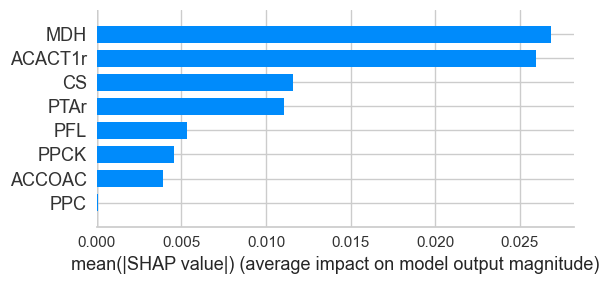

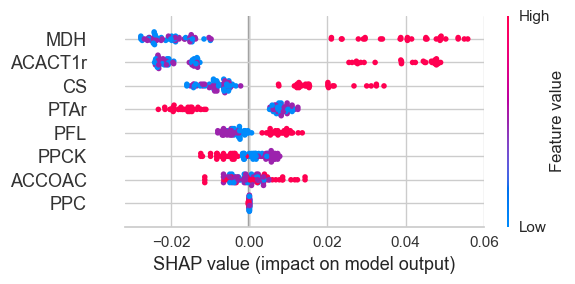

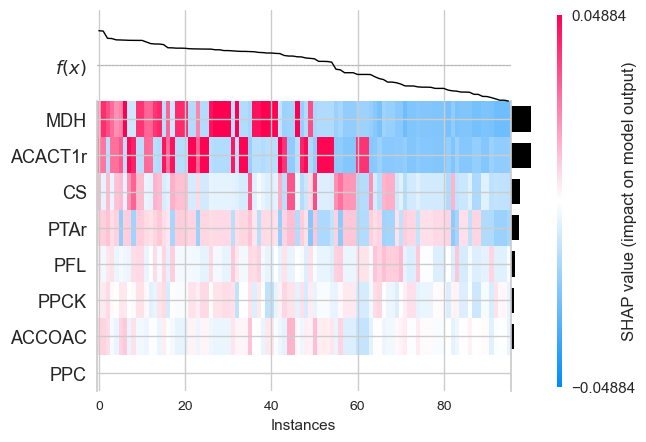

In [9]:
import shap
import matplotlib.pyplot as plt
from alibi.explainers import ALE, PartialDependence, plot_ale, plot_pd

explainer = shap.Explainer(final_model.predict, df[INPUT_VARS])
shap_values = explainer(df[INPUT_VARS])
shap.summary_plot(shap_values, df[INPUT_VARS], plot_type="bar", plot_size=(6, 3))
shap.summary_plot(shap_values, df[INPUT_VARS], plot_type="dot", plot_size=(6, 3))
shap.plots.heatmap(shap_values, instance_order=shap_values.sum(1), plot_width=6)

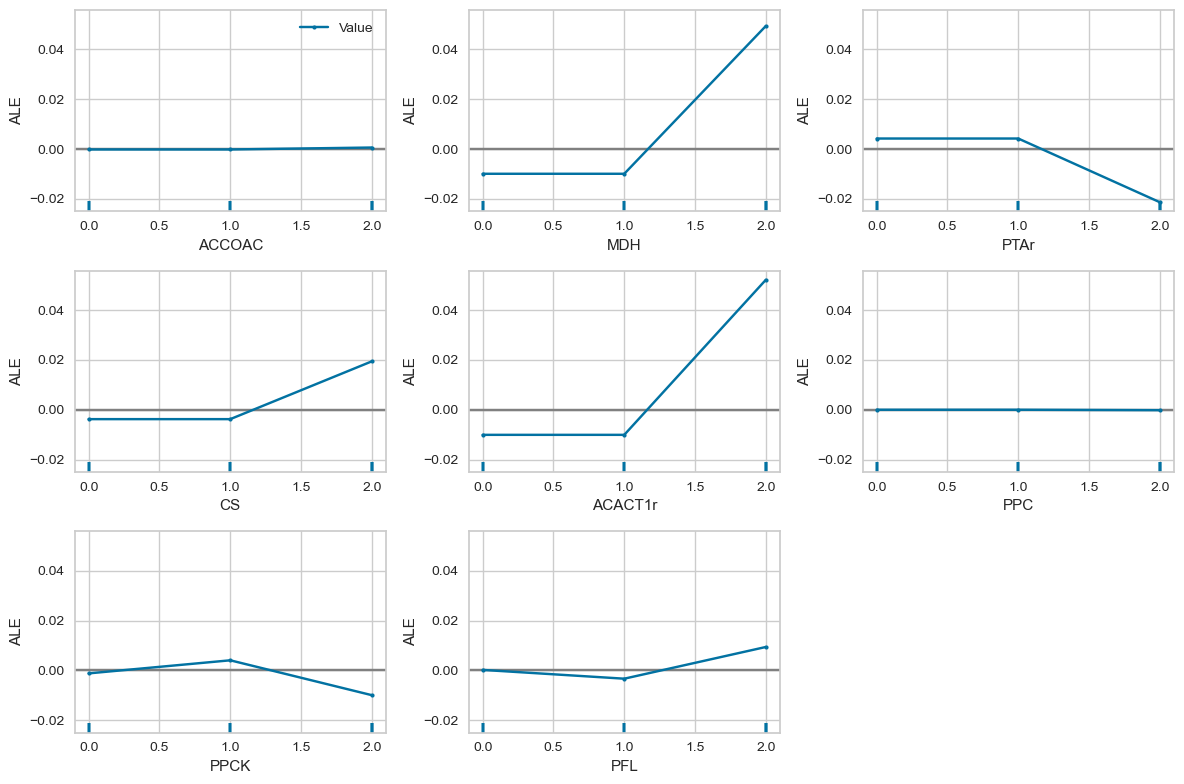

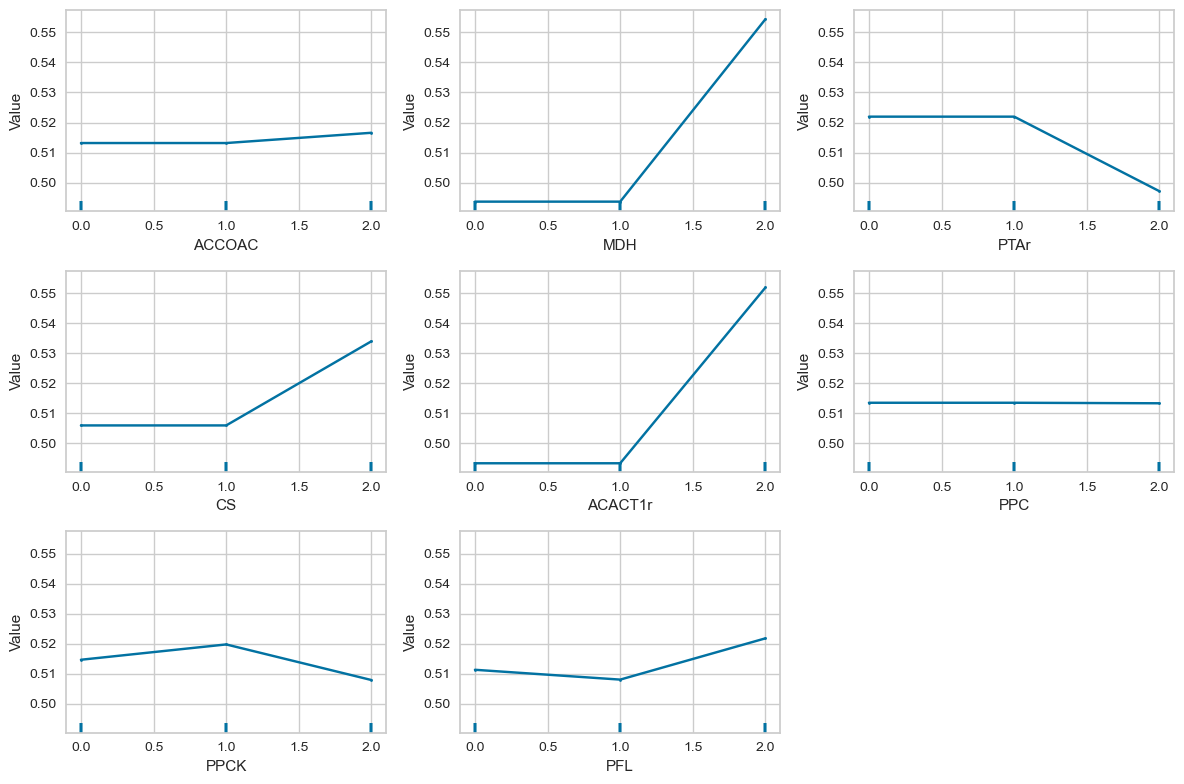

In [12]:
ale = ALE(final_model.predict, feature_names=INPUT_VARS, target_names=RESPONSE_VARS)
exp = ale.explain(df[INPUT_VARS].values)
plot_ale(exp, fig_kw={"figwidth": 12, "figheight": 8})
plt.show()

pdp = PartialDependence(
    predictor=final_model.predict, feature_names=INPUT_VARS, target_names=RESPONSE_VARS, categorical_names=INPUT_VARS
)
exp = pdp.explain(df[INPUT_VARS].values)
plot_pd(exp, fig_kw={"figwidth": 12, "figheight": 8})
plt.show()

# Sampling

# Counterfactuals (`DiCE`)

In [15]:
df

,ACCOAC,MDH,PTAr,CS,ACACT1r,PPC,PPCK,PFL,Value
Line Name,,,,,,,,,
Strain 1,1,1,2,0,2,0,0,0,0.000000
Strain 2,1,2,2,2,2,1,1,0,0.552101
Strain 3,1,0,0,2,1,1,2,0,0.349196
Strain 4,1,1,1,1,2,2,1,0,0.551849
Strain 5,2,0,2,1,1,0,1,1,0.080117
...,...,...,...,...,...,...,...,...,...
Strain 92,0,0,2,2,0,2,0,2,0.000000
Strain 93,1,2,0,0,0,2,2,0,0.000000
Strain 94,0,2,0,1,0,2,1,1,0.000000


In [16]:
import dice_ml
from dice_ml.utils import helpers

sorted_idx = df.sort_values("Value", ascending=False).index
df[INPUT_VARS] = df[INPUT_VARS].loc[sorted_idx]

def bounds_to_dict(bounds: pd.DataFrame):
    bounds_dict = bounds.to_dict()
    bounds_dict = {k: [v["min"], v["max"]] for k, v in bounds_dict.items()}
    return bounds_dict


query_instances = df[INPUT_VARS][0:1]

d = dice_ml.Data(
    dataframe=df, continuous_features=INPUT_VARS, outcome_name=RESPONSE_VARS[0]
)
m = dice_ml.Model(model=final_model, backend="sklearn", model_type="regressor")
exp = dice_ml.Dice(d, m, method="genetic")
e1 = exp.generate_counterfactuals(
    query_instances,
    total_CFs=4,
    desired_range=[0.50, 1])

cf_df = e1.cf_examples_list[0].final_cfs_df
e1.visualize_as_dataframe(show_only_changes=True)

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.18it/s]

Query instance (original outcome : 0.5216761231422424)


,ACCOAC,MDH,PTAr,CS,ACACT1r,PPC,PPCK,PFL,Value
0,1,1,2,0,2,0,0,0,0.521676



Diverse Counterfactual set (new outcome: [0.5, 1])


,ACCOAC,MDH,PTAr,CS,ACACT1r,PPC,PPCK,PFL,Value
0,-,-,-,-,-,-,-,-,-
0,0.0,-,-,-,-,-,-,-,-
0,-,-,0.0,-,-,-,-,-,0.5455505847930908
0,-,-,-,-,-,2.0,-,-,0.5213491320610046
